# Descriptive Statistics of Power Plays

The **power play** (**PP**) is a unique addition to mixed doubles curling where the team with the hammer may elect once per game to move the prepositioned stones to the right or left side, opening up the center of the ice. Many players revere this as a secret weapon to use near the end of the game and score big. To understand best how and when to use this power play, we must first look at how it is currently being used and what successes and shortcomings come from those plays.

## Load Data and Imports

In [3]:
# imports
import pandas as pd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# load Ends.csv from github
ends_path = 'https://raw.githubusercontent.com/CSAS-Data-Challenge/2026/refs/heads/main/Ends.csv'
stones_path = 'https://raw.githubusercontent.com/CSAS-Data-Challenge/2026/refs/heads/main/Stones.csv'

Ends = pd.read_csv(ends_path)
Stones = pd.read_csv(stones_path)

## Transformations

In [5]:
## Get which team has the hammer

# getting data from games is a bitch, so I'm gonna be a clever bastard and get it from stones
team_hammer = Stones[Stones['ShotID'].isin([7,8])][['CompetitionID', 'SessionID', 'GameID', 'EndID', 'ShotID', 'TeamID']]
# get the team with the hammer - or without
team_hammer['ShotID'] = team_hammer['ShotID'] - 7
team_hammer.rename(columns={'ShotID': 'Hammer'}, inplace=True)

In [6]:
## Merge onto main df
merged = pd.merge(Ends, team_hammer, on=['CompetitionID', 'SessionID', 'GameID', 'EndID', 'TeamID'])
merged['PP'] = merged['PowerPlay'].apply(lambda x: 0 if pd.isna(x) else 1)

In [7]:
def get_score_difference(group):
    """
    Computes the score difference for each team in a group (e.g., each end).
    ScoreDifference = team's score - opponent's score
    """
    if group.empty or len(group) != 2:
        # Skip if the group is empty or doesn't have exactly 2 teams
        print("Error")
        return group

    scores = group['Result'].values

    # Assign scores
    core_diff = [scores[0] - scores[1], scores[1] - scores[0]]

    # Assign to new column
    group['ScoreDifference'] = core_diff

    return group

In [8]:
df = merged.groupby(['CompetitionID', 'SessionID', 'GameID', 'EndID'], group_keys=False).apply(get_score_difference)

# Compute cumulative score difference within each GameID and TeamID
df['CumulativeScoreDifference'] = df.groupby(['CompetitionID', 'SessionID', 'GameID', 'TeamID'])['ScoreDifference'].cumsum()
df['SDLag'] = df['CumulativeScoreDifference'].shift(2)
df.loc[df['EndID'] == 1, 'SDLag'] = 0

/tmp/ipython-input-488546022.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = merged.groupby(['CompetitionID', 'SessionID', 'GameID', 'EndID'], group_keys=False).apply(get_score_difference)


In [9]:
## get if the PP has been used before
df = df.sort_values(['CompetitionID', 'SessionID', 'GameID', 'TeamID', 'EndID'])
df['PP_Remain'] = (
    df.groupby(['CompetitionID', 'SessionID', 'GameID', 'TeamID'])['PP']
      #.cumsum()
      .transform(lambda s: s.cumsum().shift(0))
      #.shift(fill_value=0)
      .gt(0)
      .astype(int)
)
# adjust to not count if the team elects to use it in the current round
df['PP_Remain'] = 1 - (df['PP_Remain'] - df['PP'])

## Analysis

### Distribution of Power Plays

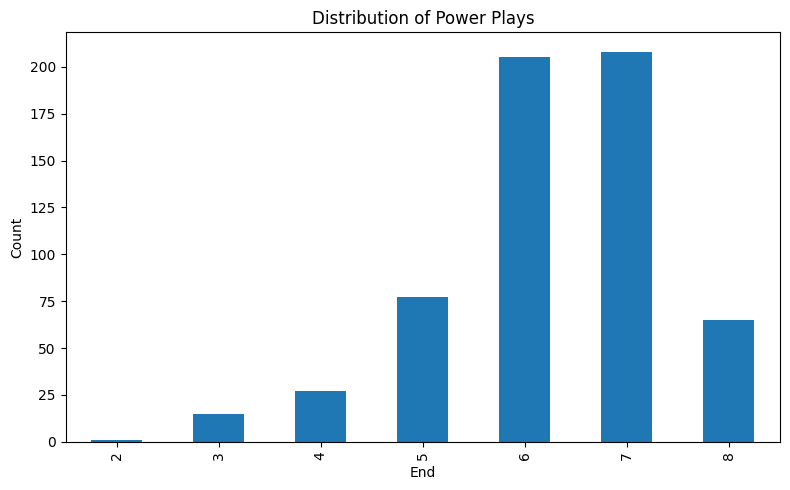

In [ ]:
# get distribution of PP use by end
counts = (
    df[df['PP'] == 1]['EndID']
    .value_counts()
    .sort_index()
)

plt.figure(figsize=(8, 5))
counts.plot(kind='bar')

plt.xlabel('End')
plt.ylabel('Count')
plt.title('Distribution of Power Plays')

plt.tight_layout()
plt.show()

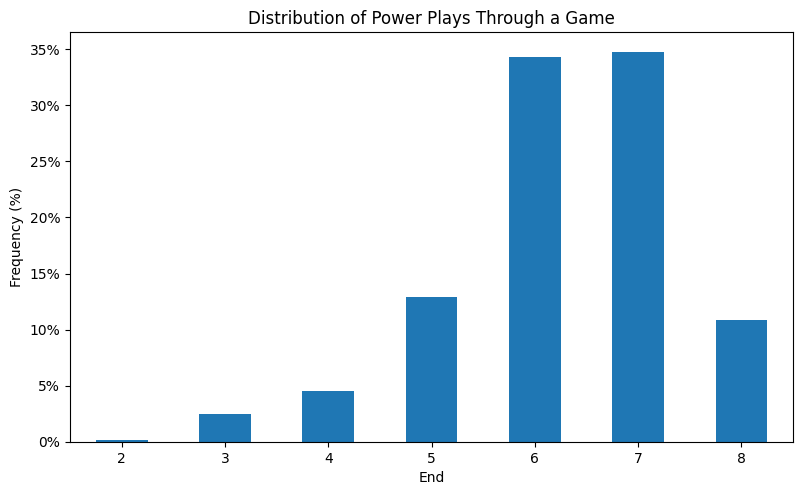

In [ ]:
percentages = counts / counts.sum() * 100

plt.figure(figsize=(8, 5))
percentages.plot(kind='bar')

plt.xlabel('End')
plt.ylabel('Frequency (%)')
plt.title('Distribution of Power Plays Through a Game')

plt.tight_layout()
plt.xticks(rotation=0)
plt.gca().yaxis.set_major_formatter(lambda x, _: f'{x:.0f}%')
plt.show()

Power Plays are typically saved for the later ends, with **67%** of all PPs done in the 6-7th ends.  They are seldom used in the opening ends, unless the team finds themselves with a very low margin of victory (MOV), defined as the difference in a team’s score relative to their opponent at the beginning of an end (ex. If Team A has 4 points and Team B has 2 at the start of the 4th end, Team A’s MOV will be 2 and Team B’s MOV will be -2 for End = 4). This follows with conventional wisdom of wanting to save the PP for the end of the game, but perhaps not wait too long and risk not being able to use it at all.

### Distribution of Points Scored

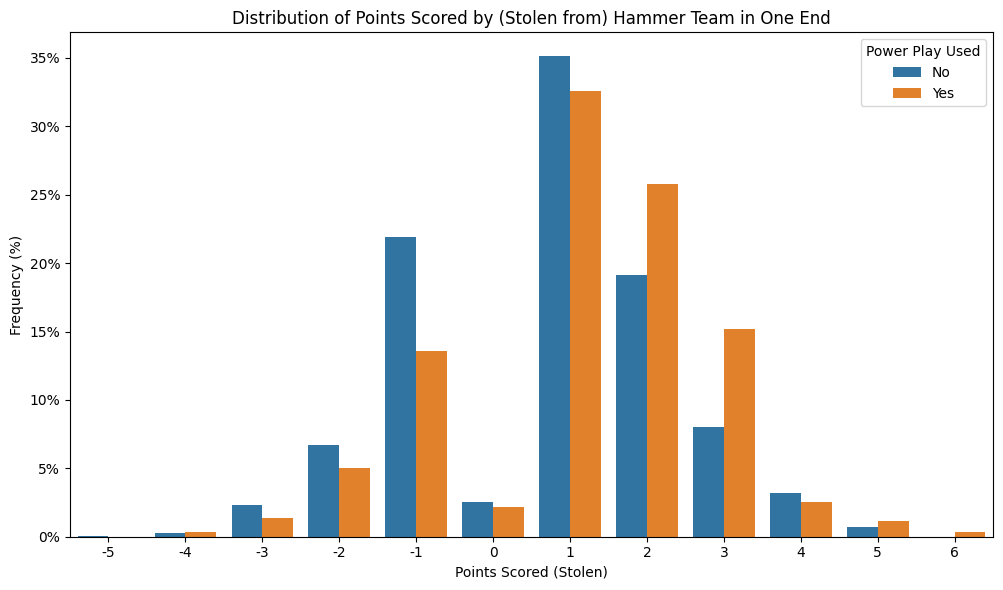

In [ ]:
# get the main data frequencies
score_diff_avg = df[df['Hammer'] == 1].groupby(['ScoreDifference', 'PP'])['ScoreDifference'].count().reset_index(name='Frequency')

# get the total count for each PowerPlay group (PP = 0 and PP = 1)
total_pp_counts = df[df['Hammer'] == 1]['PP'].value_counts().reset_index()
total_pp_counts.columns = ['PP', 'TotalCount']

# merge the total count with the frequencies to calculate percentage
score_diff_avg = pd.merge(score_diff_avg, total_pp_counts, on='PP')

# calculate percentage for each ScoreDifference
score_diff_avg['Percentage'] = (score_diff_avg['Frequency'] / score_diff_avg['TotalCount']) * 100

# map PP values to labels
score_diff_avg['Power Play Used'] = score_diff_avg['PP'].map({0: 'No', 1: 'Yes'})

plt.figure(figsize=(10, 6))

sns.barplot(
    x='ScoreDifference',
    y='Percentage',
    hue='Power Play Used',
    data=score_diff_avg
)

plt.title('Distribution of Points Scored by (Stolen from) Hammer Team in One End')
plt.xlabel('Points Scored (Stolen)')
plt.ylabel('Frequency (%)')

plt.xticks(rotation=0)
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(lambda x, _: f'{x:.0f}%')
plt.show()


***Figure 2**: Distribution of points scored by the hammer team or stolen from the hammer team while a power play was used or not during the end.*

The benefits of the PP are modest, but noticeable. Teams with the hammer score 2+ point ends much more frequently and reduce both the risk of a steal and the total points lost from a steal. Ends with 3 points scored double in frequency under a power play.

### Points Scored by MOV

In [ ]:
summary = (
    df[df['Hammer'] == 1].groupby(['CumulativeScoreDifference', 'PP'])['ScoreDifference']
      .mean()
      .reset_index(name='MeanResult')
)
summary['Power Play Used'] = summary['PP'].map({0: 'No', 1: 'Yes'})

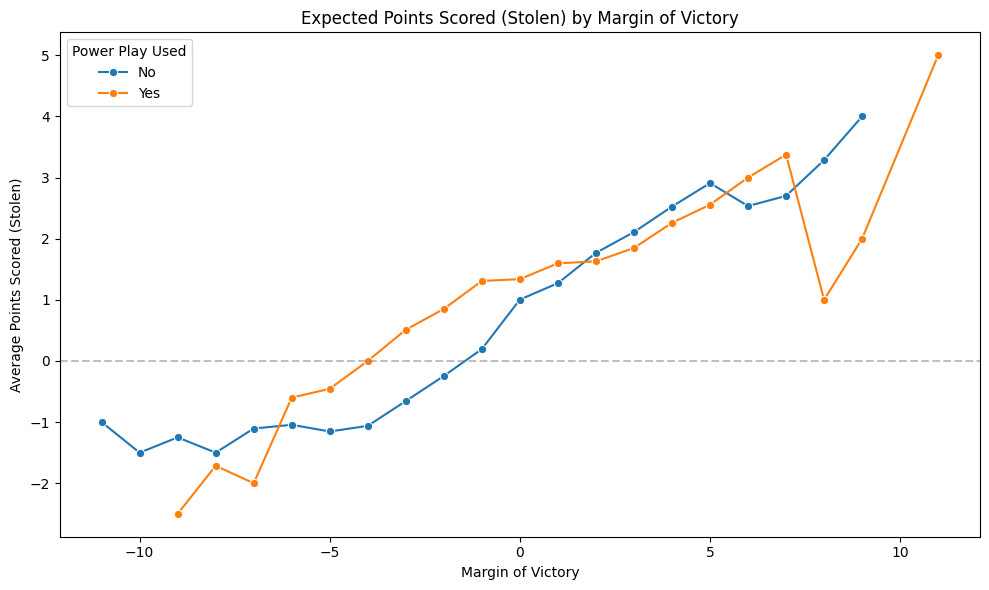

In [ ]:
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=summary,
    x='CumulativeScoreDifference',
    y='MeanResult',
    hue='Power Play Used',
    marker='o'
)

plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
plt.title('Expected Points Scored (Stolen) by Margin of Victory')
plt.xlabel('Margin of Victory')
plt.ylabel('Average Points Scored (Stolen)')

plt.tight_layout()
plt.show()


***Figure 3**: Average points scored by the hammer team or stolen from the hammer team based on the play’s given margin of victory.*

The gains from using a power play are not always distributed equally.  Points earned by the hammer team have been correlated with Margin of Victory (MOV), whether that be from momentum, skill, or a combination. Something interesting has happened for teams in close or negative MOVs though. Unlike teams with positive MOVs who can expect to score the same on a PP or not, teams with losing positions have tended to score an additional point, on average, when using a PP.

With these initial findings in mind, we have found strategies simplified to rules of thumb that can optimize the PP use of a team depending on the situation the team is in.
